(assignment09_solution)=

# Assignment #9 (demo). Time series analysis. Solution

<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />

**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>

Author: Mariya Mansurova, Analyst & developer in Yandex.Metrics team. Translated by Ivan Zakharov, ML enthusiast. <br>This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

**Same assignment as a [Kaggle Notebook](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis) + [solution](https://www.kaggle.com/kashnitsky/a9-demo-time-series-analysis-solution).**

**Fill cells marked with "Your code here" and submit your answers to the questions through the [web form](https://docs.google.com/forms/d/1UYQ_WYSpsV3VSlZAzhSN_YXmyjV7YlTP8EYMg8M8SoM/edit).**

In [1]:
import warnings

warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

print(__version__)  # need 1.9.0 or greater
init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

5.4.0


## Data preparation

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [3]:
df = pd.read_csv(DATA_PATH + "wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [4]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
plotly_df(df.set_index("date")[["count"]])

In [7]:
from prophet import Prophet

In [8]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [9]:
train_df = df[:-predictions].copy()

In [10]:
m = Prophet()
m.fit(train_df);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.51788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       768.231   0.000797845       100.429   8.428e-06       0.001      118  LS failed, Hessian reset 
      94        768.53   0.000644625       86.6531   5.317e-06       0.001      189  LS failed, Hessian reset 
      99       768.558   0.000105737       60.2116      0.6018           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       768.583    4.4291e-05       71.1494   7.124e-07       0.001      287  LS failed, Hessian reset 
     172       768.587   1.50151e-06       70.4223   2.731e-08       0.001      367  LS failed, Hessian reset 
     187       768.587   4.20131e-08       70.8813      0.5017      0.5017      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [11]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [12]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2981.107031,1670.466963,2511.401997,2962.691290,2998.234362,-861.706598,-861.706598,-861.706598,-861.706598,-861.706598,-861.706598,0.0,0.0,0.0,2119.400433
379,2016-01-17,2986.528144,1885.405163,2651.228169,2966.895309,3004.709105,-720.723367,-720.723367,-720.723367,-720.723367,-720.723367,-720.723367,0.0,0.0,0.0,2265.804777
380,2016-01-18,2991.949256,2876.084823,3676.509570,2971.167345,3011.382177,281.345187,281.345187,281.345187,281.345187,281.345187,281.345187,0.0,0.0,0.0,3273.294444
381,2016-01-19,2997.370369,3141.507179,3935.630352,2975.348648,3018.333172,541.447411,541.447411,541.447411,541.447411,541.447411,541.447411,0.0,0.0,0.0,3538.817781
382,2016-01-20,3002.791482,3031.115494,3834.525603,2979.618110,3024.649573,425.564874,425.564874,425.564874,425.564874,425.564874,425.564874,0.0,0.0,0.0,3428.356356


**<font color='red'>Question 1:</font>** What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

- 4947
- 3426 **[+]**
- 5229
- 2744

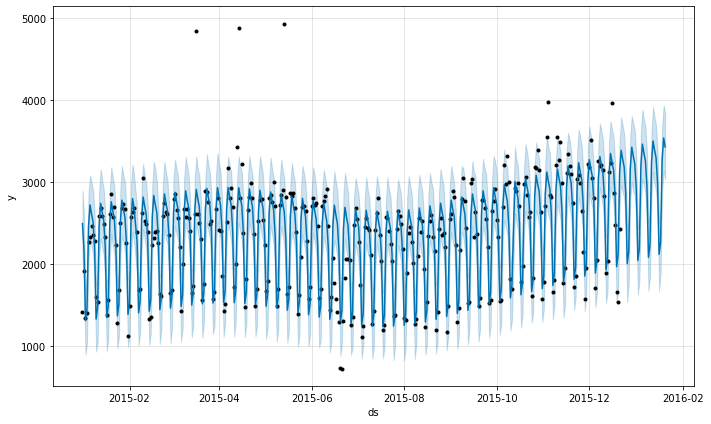

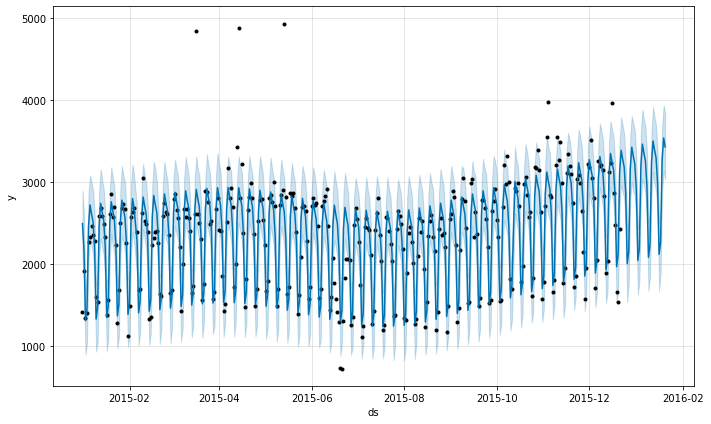

In [13]:
m.plot(forecast)

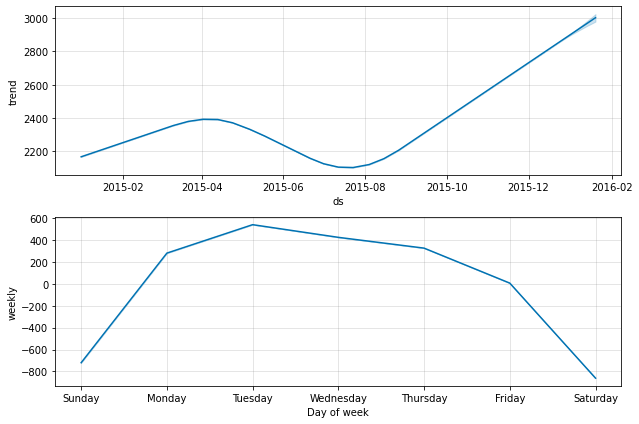

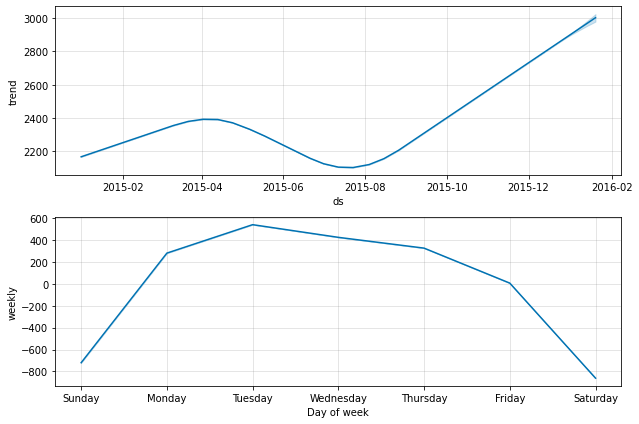

In [14]:
m.plot_components(forecast)

In [15]:
cmp_df = forecast.set_index("ds")[["yhat", "yhat_lower", "yhat_upper"]].join(
    df.set_index("ds")
)

In [16]:
cmp_df["e"] = cmp_df["y"] - cmp_df["yhat"]
cmp_df["p"] = 100 * cmp_df["e"] / cmp_df["y"]
print("MAPE = ", round(np.mean(abs(cmp_df[-predictions:]["p"])), 2))
print("MAE = ", round(np.mean(abs(cmp_df[-predictions:]["e"])), 2))

MAPE =  34.58
MAE =  601.36


Estimate the quality of the prediction with the last 30 points.

**<font color='red'>Question 2:</font> What is MAPE equal to?**

- 34.5 **[+]**
- 42.42
- 5.39
- 65.91

**<font color='red'>Question 3:</font> What is MAE equal to?**

- 355
- 4007
- 600 **[+]**
- 903

## Predicting with ARIMA

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

plt.rcParams["figure.figsize"] = (15, 10)

**<font color='red'>Question 4:</font> Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?**

- Series is stationary, p_value = 0.107
- Series is not stationary, p_value = 0.107 **[+]**
- Series is stationary, p_value = 0.001
- Series is not stationary, p_value = 0.001

Dickey-Fuller test: p=0.107392


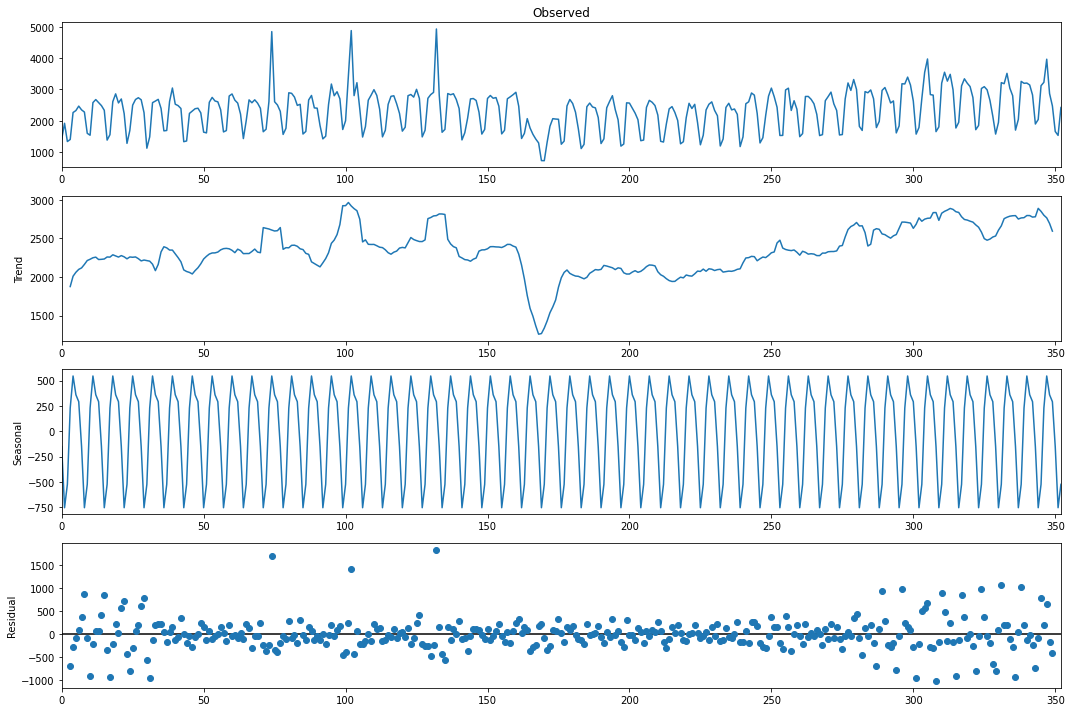

In [18]:
sm.tsa.seasonal_decompose(train_df["y"].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df["y"])[1])

But the seasonally differentiated series will already be stationary.

In [19]:
train_df.set_index("ds", inplace=True)

Dickey-Fuller test: p=0.000000


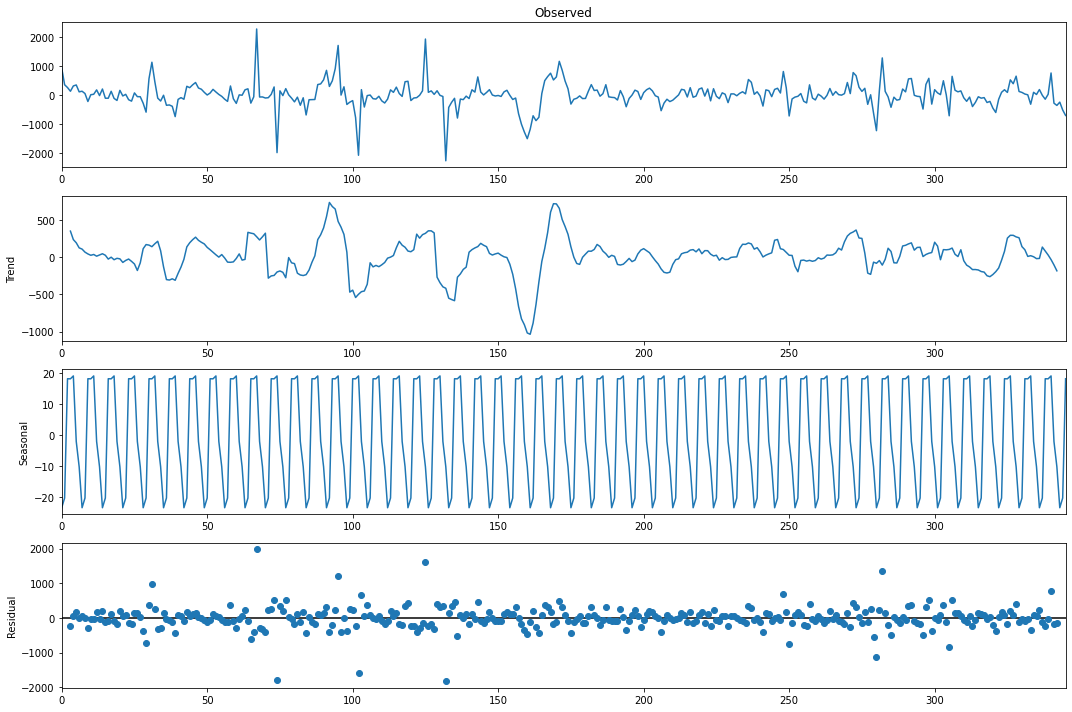

In [20]:
train_df["y_diff"] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

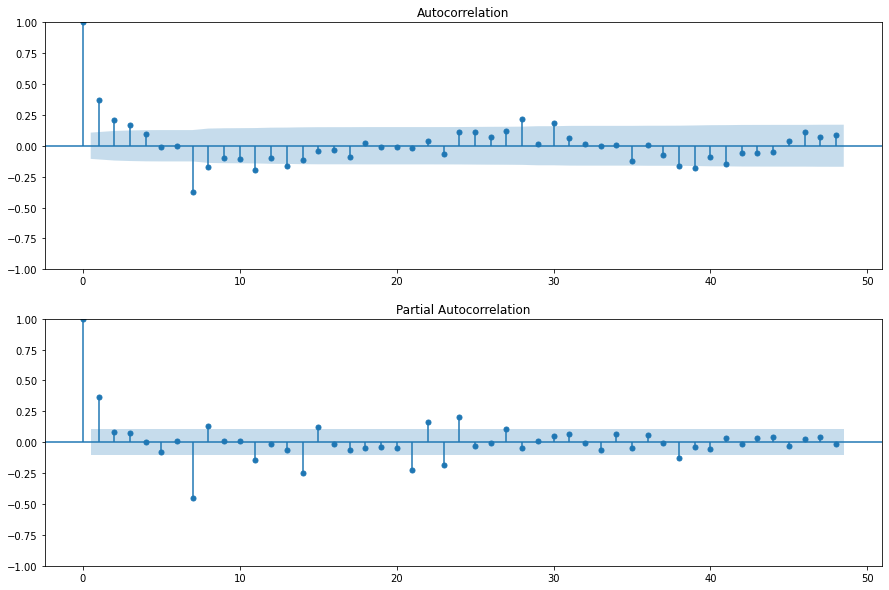

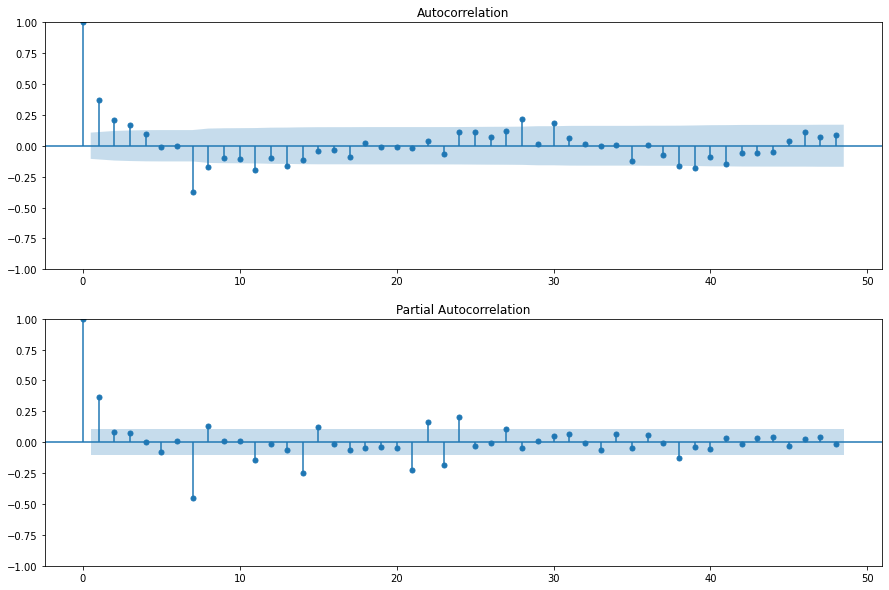

In [21]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Initial values:
* Q = 1
* q = 3
* P = 3
* p = 1

In [22]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [23]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [24]:
%%time
import warnings

from tqdm.notebook import tqdm

results1 = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
        ).fit(disp=-1)
    # print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

  0%|          | 0/384 [00:00<?, ?it/s]

CPU times: user 47min 3s, sys: 9min 35s, total: 56min 39s
Wall time: 5h 45min 1s


In [25]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ["parameters", "aic"]
print(result_table1.sort_values(by="aic", ascending=True).head())

             parameters          aic
41   (0, 0, 1, 3, 0, 1)    12.000000
375  (1, 1, 3, 3, 0, 1)    50.686791
229  (1, 0, 1, 2, 2, 1)    94.779834
349  (1, 1, 2, 2, 2, 1)  1538.043981
163  (0, 1, 2, 3, 2, 1)  4961.632628


If we consider the variants proposed in the form:

In [26]:
result_table1[
    result_table1["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
]

,parameters,aic
254,"(1, 0, 2, 3, 0, 0)",5183.807076
256,"(1, 0, 2, 3, 1, 0)",5022.312524
353,"(1, 1, 2, 3, 1, 1)",5019.555903
355,"(1, 1, 2, 3, 2, 1)",4988.974735


Now do the same, but for the series with Box-Cox transformation.

In [27]:
import scipy.stats

train_df["y_box"], lmbda = scipy.stats.boxcox(train_df["y"])
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [28]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    # try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model = sm.tsa.statespace.SARIMAX(
            train_df["y_box"],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], 7),
        ).fit(disp=-1)
    # print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    # save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])

warnings.filterwarnings("default")

  0%|          | 0/384 [00:00<?, ?it/s]

In [29]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ["parameters", "aic"]
print(result_table2.sort_values(by="aic", ascending=True).head())

             parameters          aic
83   (0, 0, 3, 2, 0, 0)    12.000000
355  (1, 1, 2, 3, 2, 0)    14.000000
90   (0, 0, 3, 3, 0, 1)    16.000000
260  (1, 0, 2, 3, 2, 1)  3528.651117
213  (1, 0, 0, 3, 2, 1)  3530.524249


If we consider the variants proposed in the form:

In [30]:
result_table2[
    result_table2["parameters"].isin(
        [(1, 0, 2, 3, 1, 0), (1, 1, 2, 3, 2, 1), (1, 1, 2, 3, 1, 1), (1, 0, 2, 3, 0, 0)]
    )
].sort_values(by="aic")

,parameters,aic
356,"(1, 1, 2, 3, 2, 1)",3534.540192
257,"(1, 0, 2, 3, 1, 0)",3556.880030
354,"(1, 1, 2, 3, 1, 1)",3557.851778
255,"(1, 0, 2, 3, 0, 0)",3674.915958


**Next, we turn to the construction of the SARIMAX model (`sm.tsa.statespace.SARIMAX`).<br> <font color='red'>Question 5:</font> What parameters are the best for the model according to the `AIC` criterion?**

- D = 1, d = 0, Q = 0, q = 2, P = 3, p = 1
- D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1 **[+]**
- D = 1, d = 1, Q = 1, q = 2, P = 3, p = 1
- D = 0, d = 0, Q = 0, q = 2, P = 3, p = 1

Let's look at the forecast of the best AIC model.

In [31]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              y_box   No. Observations:                  353
Model:             SARIMAX(0, 0, 3)x(2, 0, [], 7)   Log Likelihood                   0.000
Date:                            Tue, 28 Dec 2021   AIC                             12.000
Time:                                    10:38:49   BIC                             35.199
Sample:                                         0   HQIC                            21.231
                                            - 353                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8346         -0        inf      0.000      -0.835      -0.835
ma.L2         -0.8356         -0   

/Users/kashnitskiyy/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:2968: RuntimeWarning:

divide by zero encountered in true_divide

/Users/kashnitskiyy/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1339: RuntimeWarning:

invalid value encountered in true_divide

/Users/kashnitskiyy/opt/anaconda3/envs/mlcourse/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning:

invalid value encountered in true_divide



Student's test: p=0.000000


Dickey-Fuller test: p=0.119300


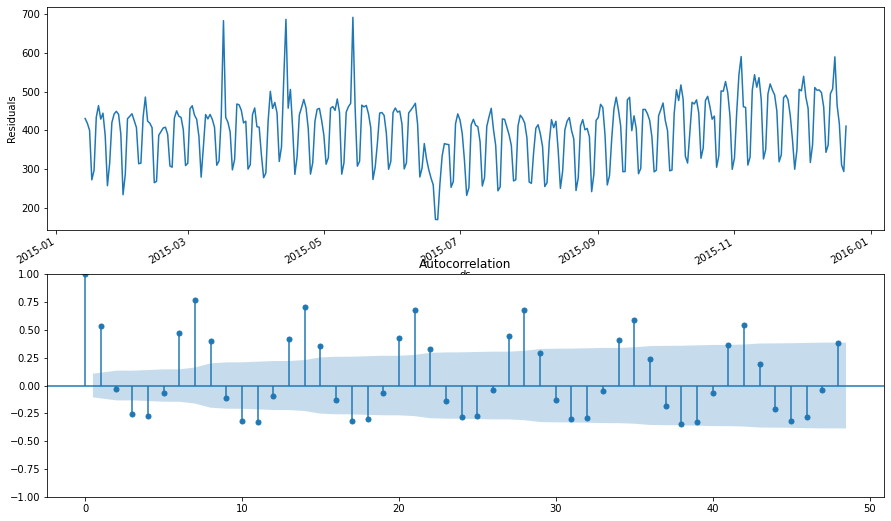

In [32]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u"Residuals")

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [33]:
def invboxcox(y, lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

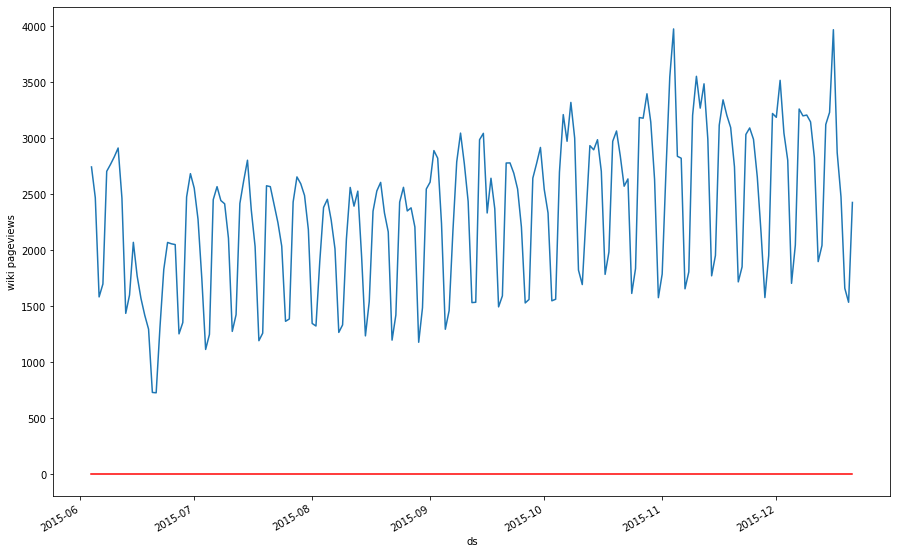

In [34]:
train_df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)

train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color="r")
plt.ylabel("wiki pageviews");